<a href="https://colab.research.google.com/github/tfjgeorge/nngeometry-examples/blob/main/display_and_timings/Timings%20and%20display%20of%20FIM%20representations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! touch resnet.py

In [2]:
!pip install git+https://github.com/tfjgeorge/nngeometry.git

  Cloning https://github.com/tfjgeorge/nngeometry.git to /tmp/pip-req-build-edp1j19b
  Running command git clone --filter=blob:none --quiet https://github.com/tfjgeorge/nngeometry.git /tmp/pip-req-build-edp1j19b
  Resolved https://github.com/tfjgeorge/nngeometry.git to commit c320881caf91126216a3305b3a13966b4ca48760
  Preparing metadata (setup.py) ... done


We compare different representations on two datasets/architectures:

 - A small convnet on MNIST with 1,001 parameters on the full MNIST dataset
 - A Resnet50 on CIFAR10 with 23,467,722 parameters on 100 CIFAR10 examples

In the convnet example, since we do not have so many parameters, we are also able to visualize FIMs.

In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
import torch.nn.functional as tF
import torch.nn as nn
import time

import matplotlib.pyplot as plt


from nngeometry.layercollection import LayerCollection
from nngeometry.metrics import FIM_MonteCarlo
from nngeometry.object.vector import random_pvector

from nngeometry.object import PMatDiag, PMatKFAC, PMatEKFAC, PMatLowRank, PMatBlockDiag, PMatQuasiDiag, PMatImplicit, PVector, PMatDense

# Small convnet on MNIST

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, 3, 1)
        self.conv2 = nn.Conv2d(5, 6, 4, 1)
        self.conv3 = nn.Conv2d(6, 7, 3, 1)
        self.fc1 = nn.Linear(1*1*7, 10)

    def forward(self, x):
        x = tF.relu(self.conv1(x))
        x = tF.max_pool2d(x, 2, 2)
        x = tF.relu(self.conv2(x))
        x = tF.max_pool2d(x, 2, 2)
        x = tF.relu(self.conv3(x))
        x = tF.max_pool2d(x, 2, 2)
        x = x.view(-1, 1*1*7)
        x = self.fc1(x)
        return tF.log_softmax(x, dim=1)

trainset = datasets.MNIST(root='/tmp/', train=True, download=True,
                           transform=transforms.ToTensor())
trainloader = DataLoader(
    dataset=trainset,
    batch_size=1000,
    shuffle=False)

convnet = ConvNet().to('cuda')

layer_collection = LayerCollection.from_model(convnet)
v = random_pvector(LayerCollection.from_model(convnet), device='cuda', dtype=torch.float32)

layer_collection.numel()

1001

In [5]:
def compute_correlation(M):
    diag = torch.diag(M)
    dM = (diag + diag.mean() / 100) **.5
    return torch.abs(M) / dM.unsqueeze(0) / dM.unsqueeze(1)

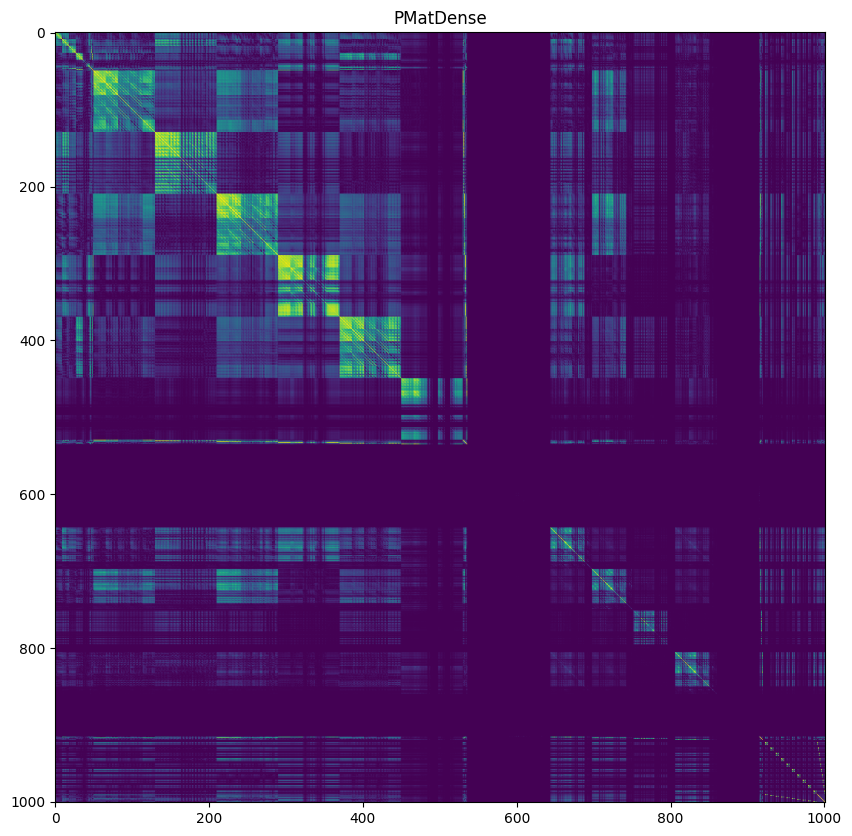

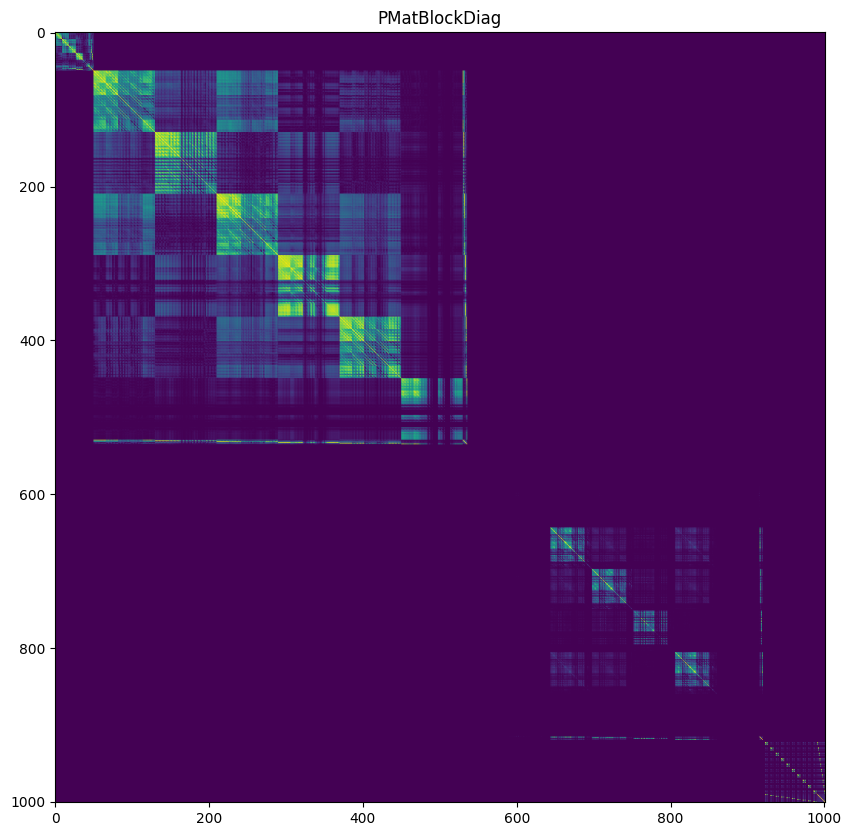

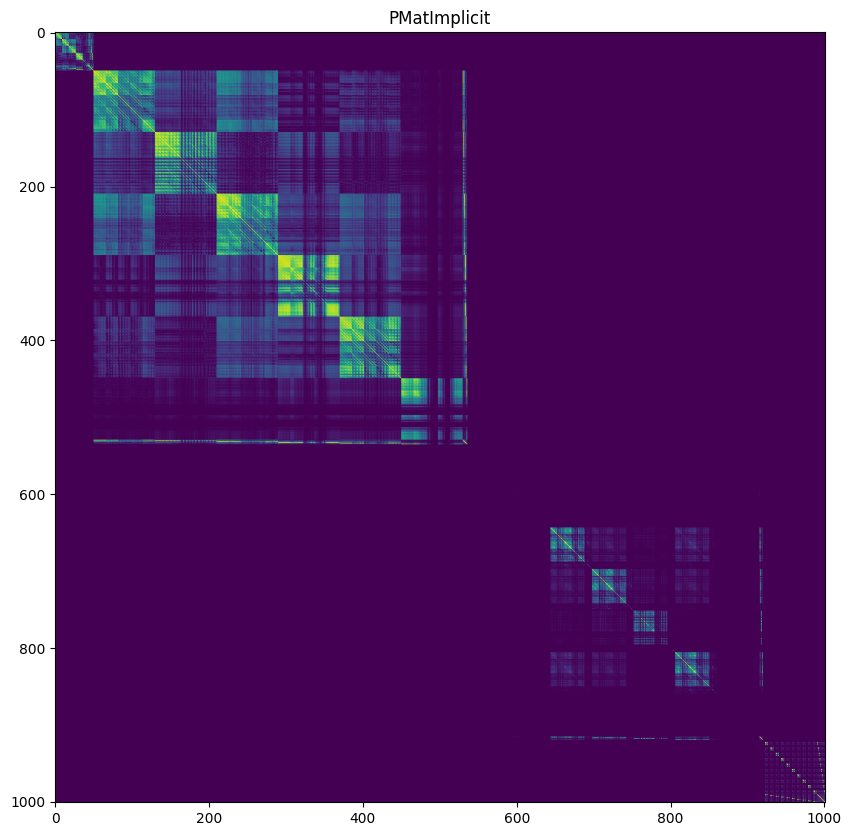

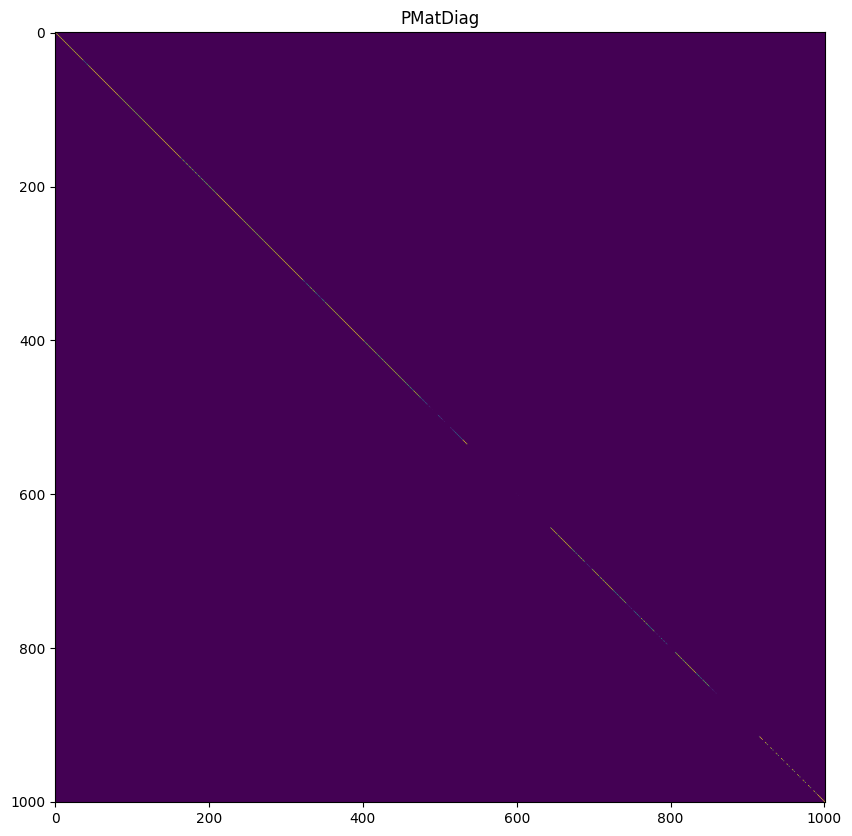

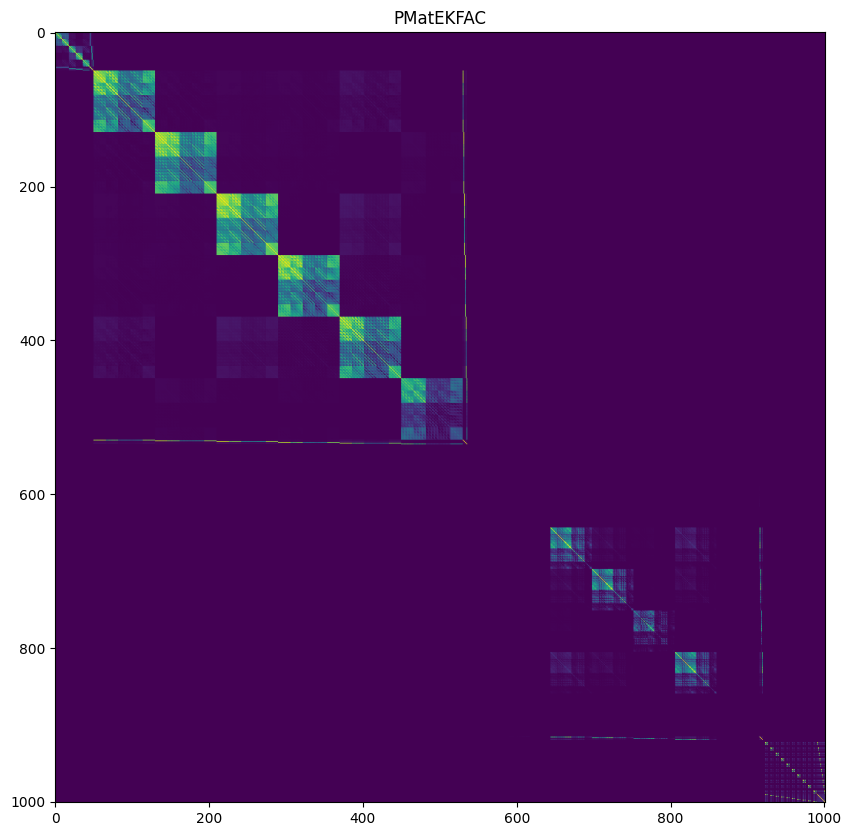

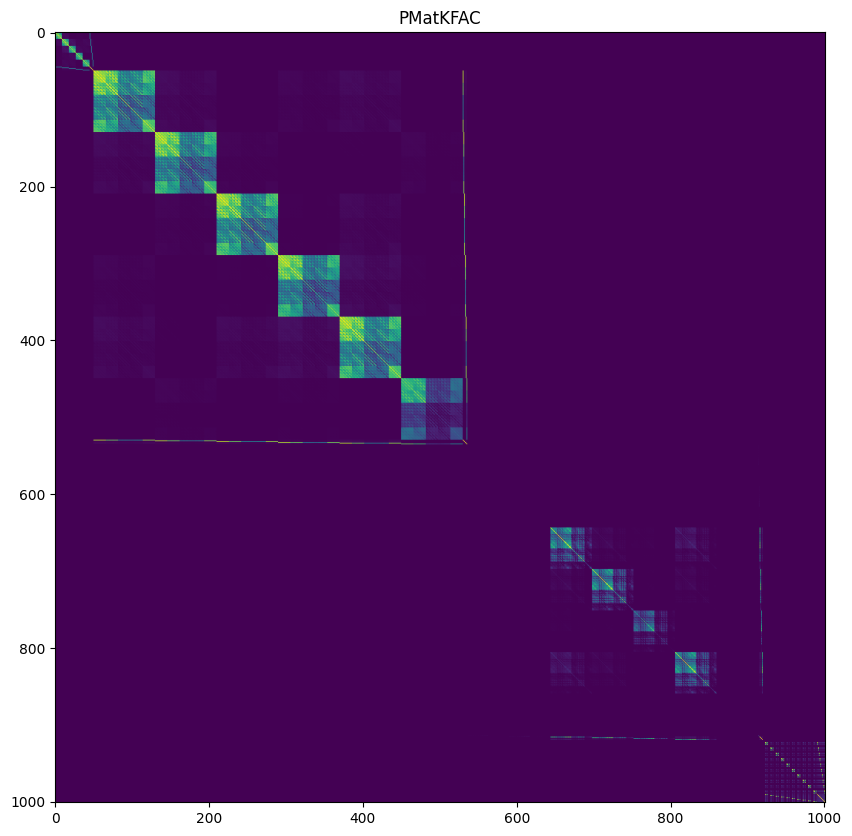

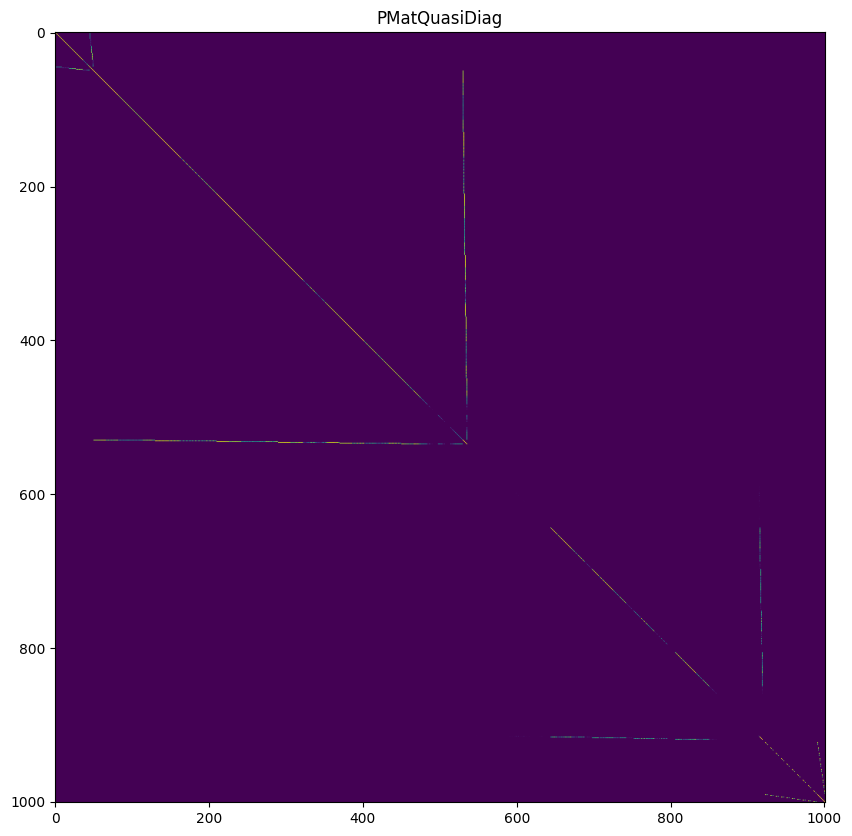

In [6]:
# compute timings and display FIMs

timings = dict()

for repr in [PMatDense, PMatBlockDiag, PMatImplicit, PMatDiag, PMatEKFAC, PMatKFAC, PMatQuasiDiag]:

    timings[repr] = dict()

    time_start = time.time()
    F = FIM_MonteCarlo(model=convnet,
                       loader=trainloader,
                       representation=repr,
                       device='cuda')
    time_end = time.time()
    timings[repr]['init'] = time_end - time_start

    if repr == PMatEKFAC:
        time_start = time.time()
        F.update_diag(examples=trainloader)
        time_end = time.time()
        timings[repr]['update_diag'] = time_end - time_start

    time_start = time.time()
    F.mv(v)
    time_end = time.time()
    timings[repr]['Mv'] = time_end - time_start

    time_start = time.time()
    F.vTMv(v)
    time_end = time.time()
    timings[repr]['vTMv'] = time_end - time_start

    time_start = time.time()
    F.trace()
    time_end = time.time()
    timings[repr]['tr'] = time_end - time_start

    try:
        time_start = time.time()
        F.frobenius_norm()
        time_end = time.time()
        timings[repr]['frob'] = time_end - time_start
    except NotImplementedError:
        pass

    try:
        time_start = time.time()
        F.solve(v)
        time_end = time.time()
        timings[repr]['solve'] = time_end - time_start
    except:
        pass

    try:
        time_start = time.time()
        F_dense = F.get_dense_tensor()
        time_end = time.time()
        timings[repr]['get_dense'] = time_end - time_start
    except:
        pass

    try:
        repr_name = str(repr).split('.')[-1][:-2]
        plt.figure(figsize=(10, 10))
        plt.imshow(compute_correlation(F_dense).cpu())
        plt.title(repr_name)
        plt.savefig('repr_img/'+ repr_name + '.png')
        plt.show()
        plt.close()

        del F_dense

    except:
        pass

    del F

In [7]:
timings

{nngeometry.object.pspace.PMatDense: {'init': 13.769831895828247,
  'Mv': 0.0015454292297363281,
  'vTMv': 0.0005199909210205078,
  'tr': 8.630752563476562e-05,
  'frob': 0.021451711654663086,
  'solve': 0.045856475830078125,
  'get_dense': 2.86102294921875e-06},
 nngeometry.object.pspace.PMatBlockDiag: {'init': 8.034695386886597,
  'Mv': 0.0043561458587646484,
  'vTMv': 0.00048351287841796875,
  'tr': 0.0001423358917236328,
  'frob': 0.02109980583190918,
  'solve': 0.009034156799316406,
  'get_dense': 0.00014901161193847656},
 nngeometry.object.pspace.PMatImplicit: {'init': 0.00014591217041015625,
  'Mv': 5.73535943031311,
  'vTMv': 6.550593376159668,
  'tr': 7.359639406204224},
 nngeometry.object.pspace.PMatDiag: {'init': 8.018492221832275,
  'Mv': 3.218650817871094e-05,
  'vTMv': 5.5789947509765625e-05,
  'tr': 2.3126602172851562e-05,
  'frob': 7.104873657226562e-05,
  'solve': 7.033348083496094e-05,
  'get_dense': 6.866455078125e-05},
 nngeometry.object.pspace.PMatEKFAC: {'init': 8

# ResNet50 on CIFAR10

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='/tmp/data', train=True,
                                        download=True, transform=transform)
trainset = torch.utils.data.Subset(trainset, range(100))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=False, num_workers=1)

Files already downloaded and verified


In [9]:
from resnet import ResNet50
resnet = ResNet50().cuda()

layer_collection = LayerCollection.from_model(resnet)
v = random_pvector(LayerCollection.from_model(resnet), device='cuda', dtype=torch.float32)

layer_collection.numel()

23467722

In [10]:
# compute timings and display FIMs

timings = dict()

for repr in [PMatImplicit, PMatDiag, PMatEKFAC, PMatKFAC, PMatQuasiDiag]:

    timings[repr] = dict()

    time_start = time.time()
#     F = repr(generator=generator)
    F = FIM_MonteCarlo(model=resnet,
                        loader=trainloader,
                        representation=repr,
                        device='cuda')
    time_end = time.time()
    timings[repr]['init'] = time_end - time_start

    if repr == PMatEKFAC:
        time_start = time.time()
        F.update_diag(examples=trainloader)
        time_end = time.time()
        timings[repr]['update_diag'] = time_end - time_start

    time_start = time.time()
    F.mv(v)
    time_end = time.time()
    timings[repr]['Mv'] = time_end - time_start

    time_start = time.time()
    F.vTMv(v)
    time_end = time.time()
    timings[repr]['vTMv'] = time_end - time_start

    time_start = time.time()
    F.trace()
    time_end = time.time()
    timings[repr]['tr'] = time_end - time_start

    try:
        time_start = time.time()
        F.frobenius_norm()
        time_end = time.time()
        timings[repr]['frob'] = time_end - time_start
    except NotImplementedError:
        pass

    try:
        time_start = time.time()
        F.solve(v)
        time_end = time.time()
        timings[repr]['solve'] = time_end - time_start
    except:
        pass

    del F

In [11]:
timings

{nngeometry.object.pspace.PMatImplicit: {'init': 0.0008976459503173828,
  'Mv': 0.6266293525695801,
  'vTMv': 0.34142422676086426,
  'tr': 0.6532025337219238},
 nngeometry.object.pspace.PMatDiag: {'init': 0.6433653831481934,
  'Mv': 8.797645568847656e-05,
  'vTMv': 7.2479248046875e-05,
  'tr': 4.482269287109375e-05,
  'frob': 9.012222290039062e-05,
  'solve': 6.747245788574219e-05},
 nngeometry.object.pspace.PMatEKFAC: {'init': 5.535670042037964,
  'update_diag': 1.0135149955749512,
  'Mv': 0.009136438369750977,
  'vTMv': 0.005392789840698242,
  'tr': 0.0010619163513183594,
  'frob': 0.0015764236450195312,
  'solve': 0.047080278396606445},
 nngeometry.object.pspace.PMatKFAC: {'init': 0.8075621128082275,
  'Mv': 0.0038230419158935547,
  'vTMv': 0.004161834716796875,
  'tr': 0.0022377967834472656,
  'frob': 0.005254030227661133,
  'solve': 1.1840107440948486},
 nngeometry.object.pspace.PMatQuasiDiag: {'init': 0.548426628112793,
  'Mv': 0.0030133724212646484,
  'vTMv': 0.00492119789123535